In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

In [2]:
#df = pd.read_csv("data/testdata_000000000001.csv", index_col="clusterid")
df = pd.concat([pd.read_csv(f,index_col="clusterid") for f in glob.glob('data/testdata_*.csv')])

In [3]:
df[df.isnull().any(axis=1)]

,out_degree,in_degree,total_degree,active_days,degree_per_active_day,total_amount_received,avg_amount_received,total_amount_sent,avg_amount_sent
clusterid,,,,,,,,,


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9206336 entries, 697406996 to 172879236
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   out_degree             9206336 non-null  int64  
 1   in_degree              9206336 non-null  int64  
 2   total_degree           9206336 non-null  int64  
 3   active_days            9206336 non-null  int64  
 4   degree_per_active_day  9206336 non-null  float64
 5   total_amount_received  9206336 non-null  int64  
 6   avg_amount_received    9206336 non-null  float64
 7   total_amount_sent      9206336 non-null  int64  
 8   avg_amount_sent        9206336 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 702.4 MB


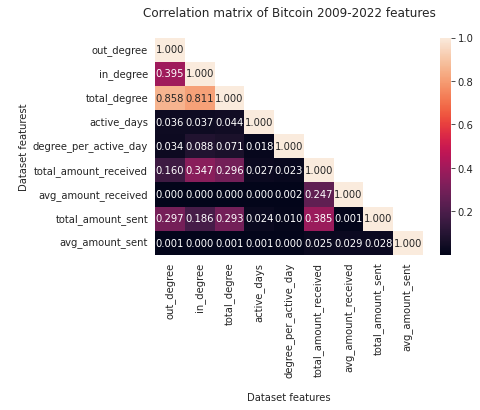

In [5]:
corr = df.corr().abs()

hm = sns.heatmap(corr, annot = True, fmt="0.3f",  mask = ~np.tril(np.ones(corr.shape)).astype(bool))

hm.set(xlabel='\nDataset features', ylabel='\nDataset featurest', title = "Correlation matrix of Bitcoin 2009-2022 features\n")

plt.savefig("heatmap.pdf")
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Correlation >=0.8 can 'confuse the model' and were extracted
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= 0.8)]
print(f"Removing strong correlated columns: {to_drop}")

df.drop(columns=to_drop, axis=1,inplace=True)


#df[df.columns] = StandardScaler().fit_transform(df[df.columns])

print(df.head())
print(df.info(show_counts=True))


Removing strong correlated columns: ['total_degree']
           out_degree  in_degree  active_days  degree_per_active_day  \
clusterid                                                              
697406996           1         96            1              96.000000   
191661552          25         19           36               0.527778   
309571277           1         11            1              11.000000   
460376044           5         13            1              13.000000   
188649361           1         14            1              14.000000   

           total_amount_received  avg_amount_received  total_amount_sent  \
clusterid                                                                  
697406996              365262462         3.652625e+08          365248913   
191661552             3796783352         1.518713e+08         6138948219   
309571277             1697281846         1.697282e+09         1697224643   
460376044              523564927         1.047130e+08         

In [7]:
sample = df.sample(10000,random_state=42)

In [8]:
# #############################################################################
# Compute DBSCAN
from sklearn import metrics
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(sample)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

sample["labels"] = labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
#print(
#    "Adjusted Mutual Information: %0.3f"
#    % metrics.adjusted_mutual_info_score(labels_true, labels)
#)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sample, labels))

Estimated number of clusters: 3
Estimated number of noise points: 9973
Silhouette Coefficient: -0.910


In [13]:
sample.labels.value_counts()

-1    9973
 0      12
 2       9
 1       6
Name: labels, dtype: int64

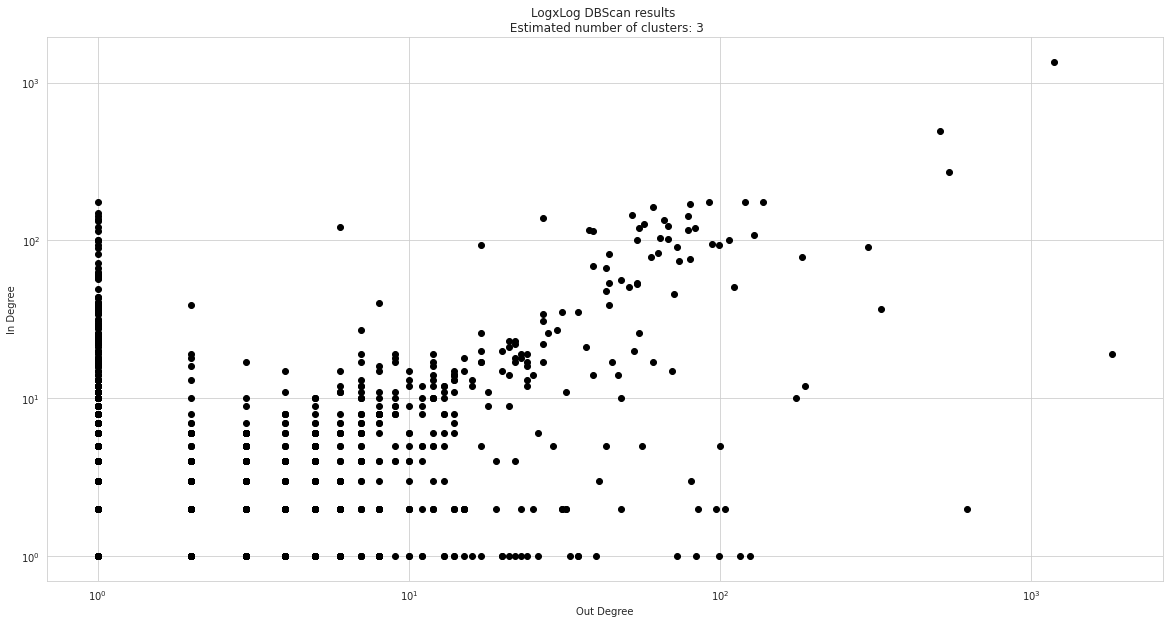

In [14]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(20,10))
ax = plt.gca()

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = sample[class_member_mask & core_samples_mask]
    plt.plot(xy.out_degree,xy.in_degree,"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=14)

    xy = sample[class_member_mask & ~core_samples_mask]
    plt.plot(xy.out_degree, xy.in_degree,"o",markerfacecolor=tuple(col),markeredgecolor="k",markersize=6)

ax.set_yscale('log')
ax.set_xscale('log')

plt.title("LogxLog DBScan results \n Estimated number of clusters: %d" % n_clusters_)

plt.xlabel("Out Degree") # X-axis label
plt.ylabel("In Degree") # Y-axis label

plt.savefig("clustering.pdf")
plt.show()

In [11]:
sample.head()

,out_degree,in_degree,active_days,degree_per_active_day,total_amount_received,avg_amount_received,total_amount_sent,avg_amount_sent,labels
clusterid,,,,,,,,,
29481527,2,2,1,2.0,1105414,5.527070e+05,2173528,1086764.0,-1
95567879,1,3,1,3.0,1145872445,1.145872e+09,1145822445,381940815.0,-1
168364763,1,2,1,2.0,4867395,4.867395e+06,4830421,2415210.5,-1
117064969,5,2,1,2.0,11158117,2.231623e+06,23741990,11870995.0,-1
7382814,2,2,1,2.0,108033209,5.401660e+07,118366418,59183209.0,-1


In [12]:
sample.labels.to_csv("clustering_results.csv",chunksize=4608828)